# Time Series Forecasting

This notebook demonstrates the process of forecasting 2023 data using the ARIMA model. 
It includes data loading, preparation, transformation, stationarity checking, ARIMA model training, forecasting, and evaluation.


In [5]:
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings

warnings.filterwarnings("ignore")

In [6]:
# Load datasets for each year
data_2019 = pd.read_csv('2019.csv')
data_2020 = pd.read_csv('2020.csv')
data_2021 = pd.read_csv('2021.csv')
data_2022 = pd.read_csv('2022.csv')
data_2023 = pd.read_csv('2023.csv')

# Function to transform yearly data into a long format
def transform_dataset(df, year):
    melted_df = df.melt(id_vars=["Província", "Distrito"], var_name="Week", value_name="Value")
    first_jan = datetime(year, 1, 1)
    first_monday = first_jan + timedelta(days=(7-first_jan.weekday()))
    melted_df['Week'] = melted_df['Week'].str.extract('W(\d+)').astype(int)
    melted_df['Date'] = melted_df['Week'].apply(lambda x: first_monday + timedelta(weeks=x-1))
    return melted_df[['Date', 'Value']]

# Transform and combine datasets
datasets = [data_2019, data_2020, data_2021, data_2022, data_2023]
years = [2019, 2020, 2021, 2022, 2023]
combined_data = pd.concat([transform_dataset(datasets[i], years[i]) for i in range(5)])

# Aggregate weekly data
combined_data = combined_data.groupby('Date')['Value'].sum().reset_index()
combined_data.set_index('Date', inplace=True)

## Stationarity Check

In [7]:
# Check for stationarity
def check_stationarity(timeseries):
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'    {key}: {value}')

check_stationarity(combined_data['Value'])

ADF Statistic: -4.844434791539266
p-value: 4.468381991526131e-05
Critical Values:
    1%: -3.4566744514553016
    5%: -2.8731248767783426
    10%: -2.5729436702592023


## Model Training and Forecasting

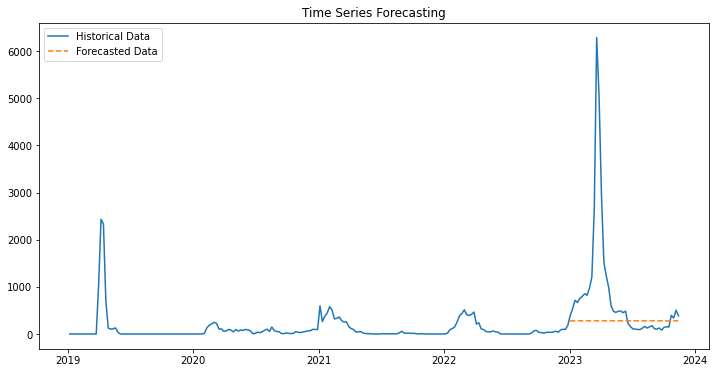

In [8]:
# Model selection and training
model = ARIMA(combined_data['Value'], order=(1,1,1))
model_fit = model.fit()

# Forecasting
forecast_steps = (combined_data.index.max() - pd.Timestamp('2023-01-01')).days // 7 + 1
forecast = model_fit.forecast(steps=forecast_steps)

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(combined_data.index, combined_data['Value'], label='Historical Data')
plt.plot(pd.date_range('2023-01-01', periods=forecast_steps, freq='W'), forecast, label='Forecasted Data', linestyle='--')
plt.legend()
plt.title('Time Series Forecasting')
plt.show()

## Evaluation

In [9]:
# Evaluation
# Assuming actual values for 2023 are available for comparison
actual_2023 = combined_data['Value']['2023']

# Calculate evaluation metrics
mse = mean_squared_error(actual_2023[:len(forecast)], forecast)
mae = mean_absolute_error(actual_2023[:len(forecast)], forecast)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')

Mean Squared Error: 1693355.9425579398
Mean Absolute Error: 613.7649453007477


In [10]:
forecast_steps_actual_2023 = len(actual_2023)  # Number of weeks in 2023 for which we have actual data
forecast_actual_2023 = model_fit.get_forecast(steps=forecast_steps_actual_2023).predicted_mean

# Creating a DataFrame to hold both actual and forecasted values for 2023
results_2023 = pd.DataFrame({
    'Date': actual_2023.index,
    'Actual': actual_2023.values,
    'Forecasted': forecast_actual_2023.values
})

# Saving the results into a CSV file
results_2023_csv_path = 'result_2023.csv'
results_2023.to_csv(results_2023_csv_path, index=False)

results_2023_csv_path

'result_2023.csv'

In [13]:
result_df = pd.read_csv('result_2023.csv')
result_df.head(10)

,Date,Actual,Forecasted
0,2023-01-02,392.0,271.726317
1,2023-01-09,536.0,279.455669
2,2023-01-16,713.0,278.923551
3,2023-01-23,670.0,278.960184
4,2023-01-30,753.0,278.957662
5,2023-02-06,797.0,278.957836
6,2023-02-13,853.0,278.957824
7,2023-02-20,821.0,278.957825
8,2023-02-27,972.0,278.957825
9,2023-03-06,1211.0,278.957825


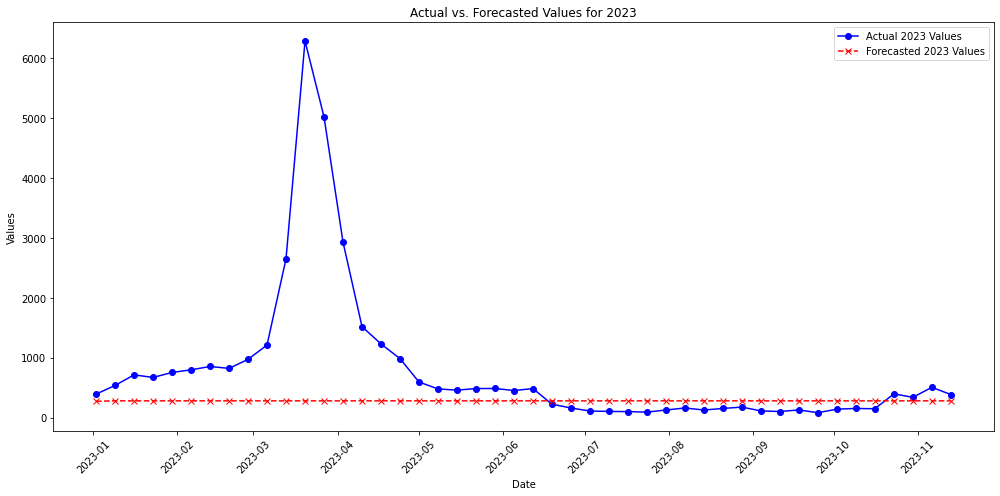

In [14]:
# Load the result data for comparison
result_2023 = result_df

# Convert 'Date' column to datetime format for plotting
result_2023['Date'] = pd.to_datetime(result_2023['Date'])

# Plotting actual vs. forecasted values
plt.figure(figsize=(14, 7))
plt.plot(result_2023['Date'], result_2023['Actual'], label='Actual 2023 Values', marker='o', color='blue')
plt.plot(result_2023['Date'], result_2023['Forecasted'], label='Forecasted 2023 Values', linestyle='--', marker='x', color='red')
plt.title('Actual vs. Forecasted Values for 2023')
plt.xlabel('Date')
plt.ylabel('Values')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [15]:
# Recalculating the evaluation metrics
mse_result = mean_squared_error(result_2023['Actual'], result_2023['Forecasted'])
mae_result = mean_absolute_error(result_2023['Actual'], result_2023['Forecasted'])
rmse_result = np.sqrt(mse_result)

mse_result, mae_result, rmse_result

(1693355.9425579398, 613.7649453007477, 1301.2901069930333)